In [1]:
import autograd.numpy as np
from autograd import grad
import pandas as pd
import sys
import matplotlib.pyplot as plt
%matplotlib inline

#### Loading the dataset

In [2]:
d = np.load("/Users/nipun/Downloads/data-2013-2017-missing.npy").item()

In [17]:
d[2016][9729].columns

Index(['use', 'air1', 'clotheswasher1', 'drye1', 'furnace1', 'kitchenapp1',
       'microwave1', 'refrigerator1'],
      dtype='object')

#### Finding homes occuring across both years

In [3]:
np.intersect1d(list(d[2016].keys()), list(d[2015].keys())).size

214

In [4]:
np.intersect1d(list(d[2017].keys()), list(d[2016].keys())).size

153

I would be choosing 2015 and 2016 as the successive years

In [5]:
use_homes = np.intersect1d(list(d[2016].keys()), list(d[2015].keys()))

In [6]:
use_homes

array([  26,   59,   77,   86,   93,   94,  101,  114,  187,  434,  484,
        499,  503,  545,  624,  744,  781,  871,  946,  974, 1086, 1103,
       1169, 1192, 1202, 1283, 1403, 1415, 1463, 1500, 1507, 1589, 1617,
       1632, 1642, 1697, 1700, 1718, 1790, 1800, 1953, 2018, 2094, 2129,
       2156, 2171, 2199, 2233, 2365, 2378, 2472, 2532, 2557, 2575, 2638,
       2755, 2787, 2814, 2818, 2829, 2859, 2945, 2953, 2965, 3009, 3039,
       3044, 3134, 3268, 3310, 3367, 3392, 3456, 3482, 3500, 3527, 3538,
       3577, 3649, 3778, 3829, 3831, 3849, 3916, 3918, 3935, 3967, 4031,
       4154, 4213, 4220, 4297, 4298, 4336, 4342, 4352, 4357, 4373, 4375,
       4473, 4514, 4641, 4767, 4874, 4946, 4957, 4998, 5026, 5060, 5129,
       5218, 5275, 5317, 5357, 5403, 5545, 5568, 5677, 5718, 5785, 5809,
       5814, 5874, 5889, 5921, 5949, 5959, 5972, 6061, 6063, 6121, 6139,
       6165, 6348, 6412, 6423, 6460, 6498, 6691, 6692, 6730, 6990, 7016,
       7030, 7361, 7390, 7429, 7504, 7536, 7560, 76

In [7]:
APPLIANCE_ORDER = ['use','air1','dishwasher1','furnace1','kitchenapp1','microwave1','refrigerator1']

### Creating the tensor data

In [8]:
t = np.empty((len(use_homes), len(APPLIANCE_ORDER), 2*12))

In [9]:
t[:] = np.NaN

In [10]:
for i, home in enumerate(use_homes):
    for j, appliance in enumerate(APPLIANCE_ORDER):
        try:
            t[i, j, :12] = d[2016][home][appliance].values
            t[i, j, 12:] = d[2017][home][appliance].values
        except:
            pass

In [11]:
t.shape

(214, 7, 24)

In [53]:
homes_chosen = [1700, 7719, 5357, 4336]

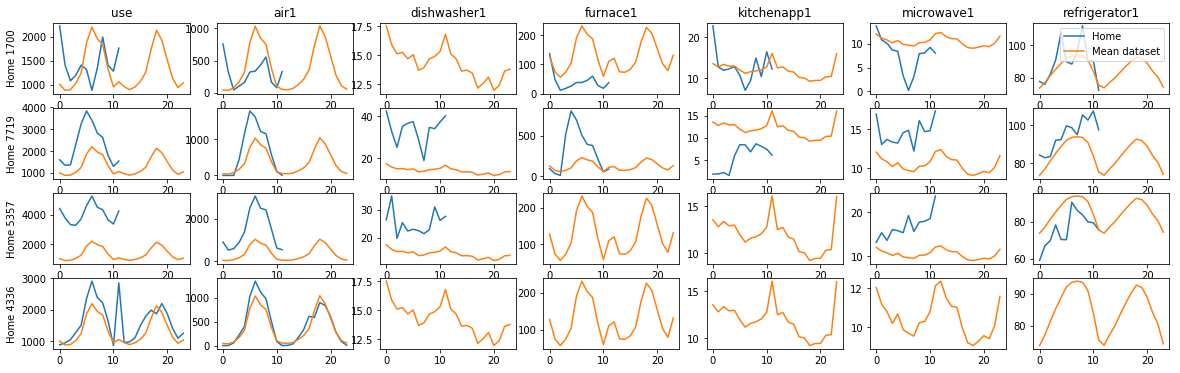

In [64]:
fig, ax = plt.subplots(nrows=len(homes_chosen), ncols=7, figsize=(20, 6))
for i, x in enumerate(homes_chosen):
    hid = np.where(use_homes==x)[0][0]
    for appliance_num, appliance in enumerate(APPLIANCE_ORDER):
        pd.Series(t[hid][appliance_num]).plot(ax=ax[i, appliance_num], label='Home')
        pd.DataFrame(t[:, appliance_num, :]).mean().plot(ax=ax[i, appliance_num], label='Mean dataset')
        ax[0, appliance_num].set_title(appliance)


    ax[i, 0].set_ylabel("Home {}".format(x))
ax[0, -1].legend()
plt.savefig("homes-picked.pdf")

### STF routine

In [15]:
def factorise(tensor, r, random_seed=0, num_iter=400, eps=1e-8, lr=1):
    np.random.seed(random_seed)
    args_num = [1, 2, 3]

    def cost(tensor, home, appliance,  month):
        pred = np.einsum('Hr, Ar, Tr ->HAT', home, appliance, month)
        mask = ~np.isnan(tensor)
        error = (pred - tensor)[mask].flatten()
        return np.sqrt((error ** 2).mean())

    mg = grad(cost, argnum=args_num)
    sizes = [(x, r) for x in tensor.shape]
    home = np.random.rand(*sizes[0])
    appliance = np.random.rand(*sizes[1])
    month = np.random.rand(*sizes[2])

    sum_home = np.zeros_like(home)
    sum_appliance = np.zeros_like(appliance)
    sum_month = np.zeros_like(month)

    # GD procedure
    for i in range(num_iter):
        del_home, del_appliance, del_month = mg(tensor, home, appliance, month)

        sum_home += eps + np.square(del_home)
        lr_home = np.divide(lr, np.sqrt(sum_home))
        home -= lr_home * del_home

        sum_appliance += eps + np.square(del_appliance)
        lr_appliance = np.divide(lr, np.sqrt(sum_appliance))
        appliance -= lr_appliance * del_appliance

        sum_month += eps + np.square(del_month)
        lr_month = np.divide(lr, np.sqrt(sum_month))
        month -= lr_month * del_month

        
        # Projection to non-negative space
        home[home < 0] = 1e-8
        appliance[appliance < 0] = 1e-8
        month[month < 0] = 1e-8

        if i % 500 == 0:
            #print(cost(tensor, home, appliance, month), i)
            sys.stdout.flush()

    return home, appliance, month

#### Creating the different subsets if data

In [16]:
# Test is last 44 homes
test_set = t[170:].copy()
# In test set, we don't know the appliance data
test_set[:, 1:, :] = np.NaN
# Train + Pool is the remaining set
train_pool_set = t[:170].copy()
# Initial train set is 10 homes
train_set = t[:10].copy()
# Initial pool set is 10-170 homes
pool_set = t[10:170].copy()
pool_homes = use_homes[10:170]
# Train + Test set (useful for factorisation)
train_test_set = np.vstack([train_set, test_set])

### Creating the set of (home, appliance) pairs for each month that can contain data and thus can be used for acquiring labels

In [17]:
p_m_h = {}
for month in range(12, 24):
    p_m_h[month] = []
    for home in pool_homes:
        for i, appliance in enumerate(APPLIANCE_ORDER[1:]):
            pool_home_index  = np.searchsorted(use_homes, home)
            if np.isfinite(t[pool_home_index, i+1, month]):
                p_m_h[month].append((home, appliance))

In [18]:
p_m_h[12]

[(499, 'air1'),
 (499, 'furnace1'),
 (499, 'kitchenapp1'),
 (499, 'refrigerator1'),
 (503, 'air1'),
 (503, 'dishwasher1'),
 (503, 'furnace1'),
 (503, 'kitchenapp1'),
 (503, 'microwave1'),
 (503, 'refrigerator1'),
 (744, 'air1'),
 (781, 'air1'),
 (781, 'dishwasher1'),
 (781, 'furnace1'),
 (781, 'kitchenapp1'),
 (781, 'microwave1'),
 (781, 'refrigerator1'),
 (871, 'air1'),
 (871, 'dishwasher1'),
 (871, 'furnace1'),
 (871, 'kitchenapp1'),
 (871, 'microwave1'),
 (871, 'refrigerator1'),
 (974, 'air1'),
 (1086, 'air1'),
 (1086, 'dishwasher1'),
 (1086, 'furnace1'),
 (1086, 'microwave1'),
 (1086, 'refrigerator1'),
 (1103, 'air1'),
 (1169, 'air1'),
 (1169, 'dishwasher1'),
 (1169, 'furnace1'),
 (1169, 'kitchenapp1'),
 (1169, 'microwave1'),
 (1169, 'refrigerator1'),
 (1192, 'air1'),
 (1202, 'air1'),
 (1202, 'dishwasher1'),
 (1202, 'furnace1'),
 (1415, 'air1'),
 (1415, 'dishwasher1'),
 (1415, 'furnace1'),
 (1415, 'kitchenapp1'),
 (1415, 'microwave1'),
 (1415, 'refrigerator1'),
 (1500, 'air1'),
 (1

#### Randomly adding 5 homes every month from Pool

In [17]:
pred_df_random = {}
from copy import deepcopy
for seed in range(10):
    print("*-*-*"*20)
    print(seed)
    pool_use = np.empty((0, 7, 24))
    pool_set_iter = deepcopy(p_m_h)
    pred_df_random[seed] = {}
    pool_remove_ix = {}
    pool_remove = {}
    gt_df = {}

    for cur_iteration, month in enumerate(range(12, 24)):
        np.random.seed(seed)
        # Randomly choose `n` to remove from pool and put in training set
        pool_remove_ix[cur_iteration] = np.random.choice(range(len(pool_set_iter[month])), size=5)
        pool_remove[month] = [pool_set_iter[month][x] for x in pool_remove_ix[cur_iteration]]

        # Remove these from future months pool too
        for month_f in range(month+1, 24):
            for x in pool_remove[month]:
                if x in pool_set_iter[month_f]:
                    pool_set_iter[month_f].remove(x)


        # Getting data from `t` to create the pool_use_set
        pool_remove_homes = [x[0] for x in pool_remove[month]]
        pool_remove_homes_ix = np.searchsorted(use_homes, pool_remove_homes)

        cur_pool = t[pool_remove_homes_ix, :, :].copy()
        # All past data is unknown
        cur_pool[:, 1:, :month] = np.NaN

        # All future data for all appliances except the chosen one is known
        cur_pool[:, 1:, month:] = np.NaN
        for q, h in enumerate(pool_remove_homes_ix):
            appliance_num = APPLIANCE_ORDER.index(pool_remove[month][q][1])
            cur_pool[q, appliance_num, month:] = t[h, appliance_num, month:]

        pool_use = np.concatenate([pool_use, cur_pool])

        pool_train_test = np.concatenate([pool_use, train_test_set[:, :, :] ])

        h, a, m =factorise(pool_train_test[:, :, :month], 3)
        print(cur_iteration, month, len(pool_train_test), pool_remove[month])

        pred = np.einsum('Hr, Ar, Tr ->HAT', h, a, m)
        pred_df_random[seed][month] = pred[len(train_set)+len(pool_use):,1:, month-1:month].reshape(-1, len(APPLIANCE_ORDER)-1)
        gt_df[month] = t[170:][:, 1:, month-1:month].reshape(len(test_set), len(APPLIANCE_ORDER)-1)

*-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-*
0
0 12 59 [(4298, 'microwave1'), (1500, 'dishwasher1'), (2965, 'kitchenapp1'), (4998, 'kitchenapp1'), (7875, 'microwave1')]
1 13 64 [(4375, 'air1'), (1500, 'furnace1'), (2965, 'refrigerator1'), (5026, 'dishwasher1'), (7940, 'furnace1')]
2 14 69 [(4375, 'refrigerator1'), (1500, 'kitchenapp1'), (3134, 'air1'), (5218, 'air1'), (7951, 'dishwasher1')]
3 15 74 [(4514, 'furnace1'), (1500, 'microwave1'), (3367, 'air1'), (5218, 'refrigerator1'), (7973, 'air1')]
4 16 79 [(4946, 'air1'), (1500, 'refrigerator1'), (3367, 'furnace1'), (5275, 'kitchenapp1'), (8046, 'dishwasher1')]
5 17 84 [(4946, 'microwave1'), (1507, 'air1'), (3367, 'refrigerator1'), (5317, 'dishwasher1'), (8059, 'air1')]
6 18 89 [(4998, 'dishwasher1'), (1507, 'dishwasher1'), (3392, 'kitchenapp1'), (5545, 'kitchenapp1'), (8079, 'kitchenapp1')]
7 19 94 [(4998, 'refrigerator1'), (1507, 'furnace1'), (3392, 'refrigerator1'), (5677, 'furn

8 20 99 [(5959, 'dishwasher1'), (5809, 'air1'), (3500, 'microwave1'), (2378, 'refrigerator1'), (781, 'kitchenapp1')]
9 21 104 [(6063, 'kitchenapp1'), (5814, 'air1'), (3649, 'air1'), (2472, 'dishwasher1'), (781, 'microwave1')]
10 22 109 [(6139, 'furnace1'), (5921, 'air1'), (3778, 'air1'), (2472, 'kitchenapp1'), (781, 'refrigerator1')]
11 23 114 [(6460, 'dishwasher1'), (5959, 'air1'), (3831, 'air1'), (2532, 'dishwasher1'), (871, 'air1')]
*-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-*
6
0 12 59 [(5218, 'furnace1'), (5809, 'dishwasher1'), (2859, 'air1'), (7951, 'kitchenapp1'), (7951, 'microwave1')]
1 13 64 [(5218, 'microwave1'), (5809, 'refrigerator1'), (2859, 'dishwasher1'), (7989, 'furnace1'), (7989, 'microwave1')]
2 14 69 [(5275, 'air1'), (5874, 'air1'), (2859, 'furnace1'), (8046, 'kitchenapp1'), (8046, 'microwave1')]
3 15 74 [(5275, 'furnace1'), (5921, 'dishwasher1'), (2859, 'kitchenapp1'), (8059, 'furnace1'), (8059, 'kitchenapp1')]

### Active learning Testing

In [19]:
pool_use = np.empty((0, 7, 24))
gt_df = {}
pred_df_active = {}
pool_remove_active = {}
pool_set_active = {}
all_seen = []

for cur_iteration, month in enumerate(range(12, 13)):
    

    pred_pool = {}
    psc = pool_set.copy()
    psc[:, 1:, :] = np.NaN
    month_contri = (pd.DataFrame(train_set[:, :, month]).mean()/pd.DataFrame(train_set[:, :, month]).mean()[0]).drop(0).to_dict()
    # Starting with current data and finding the variance amongst different #Latent factors
    for r in range(2, 8):
        print(month, r)
        pool_train = np.concatenate([psc, train_set[:, :, :] ])
        h, a, m =factorise(pool_train[:, :, :month], r)
        # This gives us prediction on the pool set only
        pred_pool[r] = np.einsum('Hr, Ar, Tr ->HAT', h, a, m)[:len(pool_set)]
   

12 2
12 3
12 4
12 5
12 6
12 7


### Variance 

In [35]:
pd.DataFrame({x:pred_pool[x][:, 0, -1] for x in range(2, 8)})

,2,3,4,5,6,7
0,722.690383,849.078656,889.865758,573.999469,492.131172,688.342444
1,1233.755043,1295.224969,1288.905467,1335.400321,1321.266250,1341.765630
2,953.638283,1023.632908,1042.112038,1028.531572,1067.099313,1099.587563
3,885.641115,929.451570,924.463209,887.015283,1062.137866,1063.927532
4,693.191539,808.183113,809.046908,820.348420,840.413397,863.642233
5,489.336774,470.891659,489.401782,536.367854,582.581892,589.689228
6,814.310341,701.338660,694.536326,703.345458,696.634179,744.575143
7,903.039230,872.773898,880.562660,798.397406,826.133569,825.694307
8,462.897320,450.541240,466.778847,497.092719,488.195287,514.643566
9,1143.130369,1180.737163,1199.050396,1201.401082,1261.306236,1270.953697


In [20]:
# Finding the top-most `n` highly variance homes
# measure = std/contri
temp = []
for appliance_num, appliance in enumerate(APPLIANCE_ORDER[1:]):
    y = pd.DataFrame({r:pd.Series(pred_pool[r][:, appliance_num+1, -1])for r in range(2, 8)}).std(axis=1)
    y.index = [(x, appliance) for x in pool_homes]
    #y = (y - y.min())/(y.max()-y.min())
    temp.append(y)

print(pd.concat(temp).sort_values(ascending=False).drop(all_seen).head(10))

(4336, air1)    274.138407
(3918, air1)    191.254116
(5357, air1)    190.407229
(1507, air1)    170.708087
(7719, air1)    169.768311
(3044, air1)    152.165705
(3500, air1)    144.816484
(6691, air1)    130.561656
(7016, air1)    130.103196
(2472, air1)    129.830478
dtype: float64


In [21]:
q = (pd.concat(temp).sort_values(ascending=False).drop(all_seen))

In [22]:
q.index= [x[1] for x in q.index]
z = q.index

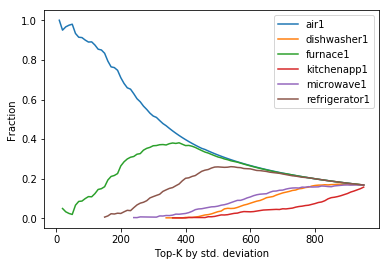

In [37]:
l = {x:pd.value_counts(z[:x]).div(x) for x in range(10, 160*6, 10)}
pd.DataFrame(l).T.plot(kind='line')
plt.xlabel("Top-K by std. deviation")
plt.ylabel("Fraction")
plt.savefig("top-k-std.pdf")

In [50]:
import matplotlib.pyplot as plt

In [37]:
pool_set[1, 1, :]

array([   0.        ,    0.        ,    0.99532795,   35.67173767,
        157.40673828,  486.01150513,  699.71569824,  575.28656006,
        520.62567139,  264.65786743,   39.34695816,    6.19594526,
          0.        ,    0.        ,    8.12929058,   82.02701569,
        180.28712463,  565.4019165 ,  853.81469727,  702.6651001 ,
        448.10568237,  165.92414856,   77.59373474,    8.57880783])

In [36]:
pool_train[1, 1, :]

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan])

In [21]:
pool_use = np.empty((0, 7, 24))
gt_df = {}
pred_df_active = {}
pool_remove_active = {}
pool_set_active = {}
all_seen = []

for cur_iteration, month in enumerate(range(12, 24)):
    
    # Get all the homes from the currently available pool

    pred_pool = {}
    psc = pool_set.copy()
    psc[:, 1:, :] = np.NaN
    month_contri = (pd.DataFrame(train_set[:, :, month]).mean()/pd.DataFrame(train_set[:, :, month]).mean()[0]).drop(0).to_dict()
    # Starting with current data and finding the variance amongst different #Latent factors
    for r in range(2, 8):
        print(month, r)
        pool_train = np.concatenate([psc, train_set[:, :, :] ])
        h, a, m =factorise(pool_train[:, :, :month], r)
        pred_pool[r] = np.einsum('Hr, Ar, Tr ->HAT', h, a, m)[:len(pool_set)]
        
    # Finding the top-most `n` highly variance homes
    # measure = std/contri
    temp = []
    for appliance_num, appliance in enumerate(APPLIANCE_ORDER[1:]):
        y = pd.DataFrame({r:pd.Series(pred_pool[r][:, appliance_num+1, -1])for r in range(2, 8)}).std(axis=1)
        y.index = [(x, appliance) for x in pool_homes]
        #y = (y - y.min())/(y.max()-y.min())
        temp.append(y)
    
    print(pd.concat(temp).sort_values(ascending=False).drop(all_seen).head(10))
        
    pool_remove_active[month] = pd.concat(temp).sort_values(ascending=False).drop(all_seen).head(5).index.tolist() 
    
    all_seen.extend(pool_remove_active[month])
    all_seen = list(set(all_seen))
    
    # Getting data from `t` to create the pool_use_set
    pool_remove_homes_active = [x[0] for x in pool_remove_active[month]]
    pool_remove_homes_active_ix = np.searchsorted(use_homes, pool_remove_homes_active)
    
    cur_pool = t[pool_remove_homes_active_ix, :, :].copy()
    # All past data is unknown
    cur_pool[:, 1:, :month] = np.NaN
    
    # All future data for all appliances except the chosen one is known
    cur_pool[:, 1:, month:] = np.NaN
    for q, h in enumerate(pool_remove_homes_active_ix):
        appliance_num = APPLIANCE_ORDER.index(pool_remove_active[month][q][1])
        cur_pool[q, appliance_num, month:] = t[h, appliance_num, month:]
    
    pool_use = np.concatenate([pool_use, cur_pool])
    
    pool_train_test = np.concatenate([pool_use, train_test_set[:, :, :] ])

    h, a, m =factorise(pool_train_test[:, :, :month], 3)
    print(cur_iteration, month, len(pool_train_test), pool_remove_active[month])
    
    pred = np.einsum('Hr, Ar, Tr ->HAT', h, a, m)
    pred_df_active[month] = pred[len(train_set)+len(pool_use):,1:, month-1:month].reshape(-1, len(APPLIANCE_ORDER)-1)
    gt_df[month] = t[170:][:, 1:, month-1:month].reshape(len(test_set), len(APPLIANCE_ORDER)-1)

12 2
12 3
12 4
12 5
12 6
12 7
(4336, air1)    274.138407
(3918, air1)    191.254116
(5357, air1)    190.407229
(1507, air1)    170.708087
(7719, air1)    169.768311
(3044, air1)    152.165705
(3500, air1)    144.816484
(6691, air1)    130.561656
(7016, air1)    130.103196
(2472, air1)    129.830478
dtype: float64
0 12 59 [(4336, 'air1'), (3918, 'air1'), (5357, 'air1'), (1507, 'air1'), (7719, 'air1')]
13 2
13 3
13 4
13 5
13 6
13 7
(3916, air1)    207.882059
(4154, air1)    207.439325
(6691, air1)    150.397463
(2365, air1)    133.469206
(3500, air1)    129.547833
(1202, air1)    122.295562
(3310, air1)    113.172361
(1589, air1)    110.597149
(484, air1)     108.742875
(974, air1)     108.516423
dtype: float64
1 13 64 [(3916, 'air1'), (4154, 'air1'), (6691, 'air1'), (2365, 'air1'), (3500, 'air1')]
14 2
14 3
14 4
14 5
14 6
14 7
(7016, air1)        116.174549
(2365, furnace1)     86.549464
(2018, air1)         77.674732
(5357, furnace1)     73.463836
(2378, air1)         71.752960
(4213, 

In [18]:
random_error = {}
#for seed in range(10):
#    random_error[seed] = {}
#    for month in range(13, 24):
#        random_error[seed][month] = (pd.DataFrame(pred_df_random[seed][month])-pd.DataFrame(gt_df[month])).abs().mean()
active_error = {}
for month in range(13, 24):
    active_error[month] = (pd.DataFrame(pred_df_active[month])-pd.DataFrame(gt_df[month])).abs().mean()

In [19]:
p = pd.Panel(random_error)

In [22]:
p.mean(axis=0)

,13,14,15,16,17,18,19,20,21,22,23
0,174.727654,98.136005,93.219758,111.226212,135.752091,245.228373,275.022541,255.978251,203.255655,168.110451,125.414486
1,13.803874,13.123776,15.784423,13.988422,14.527469,14.347852,16.992265,12.366308,9.351721,7.432315,8.081507
2,121.220506,70.803479,84.794182,99.209682,97.359031,116.056768,134.336664,128.340326,107.356612,67.897643,67.111920
3,10.012749,11.049360,10.417267,11.031750,11.815385,10.823312,10.427257,9.337735,9.760632,9.080830,8.271339
4,10.962366,7.622557,7.267819,8.777809,6.926860,7.867399,7.995557,7.609911,7.530294,6.497347,6.425706
5,38.610597,39.220722,43.054340,41.606648,42.880585,49.331856,51.551383,47.873996,43.915176,40.206062,39.478151


In [20]:
pd.DataFrame(active_error)

,13,14,15,16,17,18,19,20,21,22,23
0,146.855394,83.785468,75.036549,98.967695,144.712988,205.099340,248.609910,303.159295,206.867355,79.355259,62.736379
1,14.483744,15.198674,17.799936,13.377700,20.431925,14.908665,17.503071,16.207103,11.303742,8.930056,11.898893
2,132.393579,68.088709,95.714145,91.965661,91.460754,135.298847,147.255459,156.687668,125.594138,69.433499,77.174297
3,9.911026,10.881184,10.261232,10.759155,11.847615,10.533852,9.771363,9.626937,9.087010,8.588026,7.882614
4,9.400232,7.544331,7.136182,8.744031,5.672035,8.065303,7.797370,7.558782,6.915034,6.604377,5.755610
5,44.857410,38.596655,43.865048,39.379441,39.262394,51.317519,48.856022,58.841419,47.606366,37.378304,32.301067


In [23]:
pd.DataFrame(active_error)

,13,14,15,16,17,18,19,20,21,22,23
0,129.786957,86.714324,167.270344,132.132225,130.058033,183.863019,250.259949,155.644429,162.116530,115.005100,72.086270
1,15.506828,11.316772,11.024344,9.999262,13.518234,17.154611,14.264426,11.844534,4.785737,5.568888,7.439510
2,127.678468,67.886351,74.828083,72.925842,69.721794,102.441397,123.056763,108.426198,86.447719,62.161339,62.647331
3,10.075379,11.443909,9.994986,10.719042,11.899702,11.290874,11.027765,9.313176,11.923023,9.327450,8.292606
4,8.395629,7.737834,7.366862,8.589320,6.281333,5.322718,9.517189,7.568386,7.087605,6.628476,6.192361
5,47.190126,39.473054,41.674097,37.666890,45.890843,46.145882,48.597645,49.983295,44.101949,43.506739,47.813743


In [24]:
APPLIANCE_ORDER

['use',
 'air1',
 'dishwasher1',
 'furnace1',
 'kitchenapp1',
 'microwave1',
 'refrigerator1']

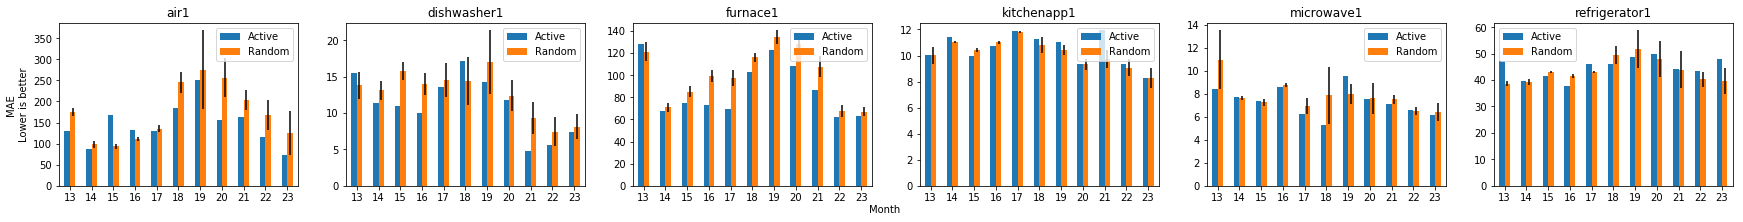

In [36]:
fig, ax = plt.subplots(ncols=6, figsize=(30, 3))
for u, appliance in enumerate(APPLIANCE_ORDER[1:]):
    appliance_num = APPLIANCE_ORDER.index(appliance)-1
    re = p.mean(axis=0).iloc[appliance_num]
    ac = pd.DataFrame(active_error).iloc[appliance_num]
    pd.DataFrame({"Random":re, "Active":ac}).plot(kind='bar',ax=ax[u], title=appliance,
                                                  yerr =[np.zeros_like(ac), p.std(axis=0).iloc[appliance_num]], rot=0)
fig.text(0.5, 0, "Month")
ax[0].set_ylabel("MAE \nLower is better")
plt.savefig("comparison-active.pdf")
plt.savefig("comparison-active.png")

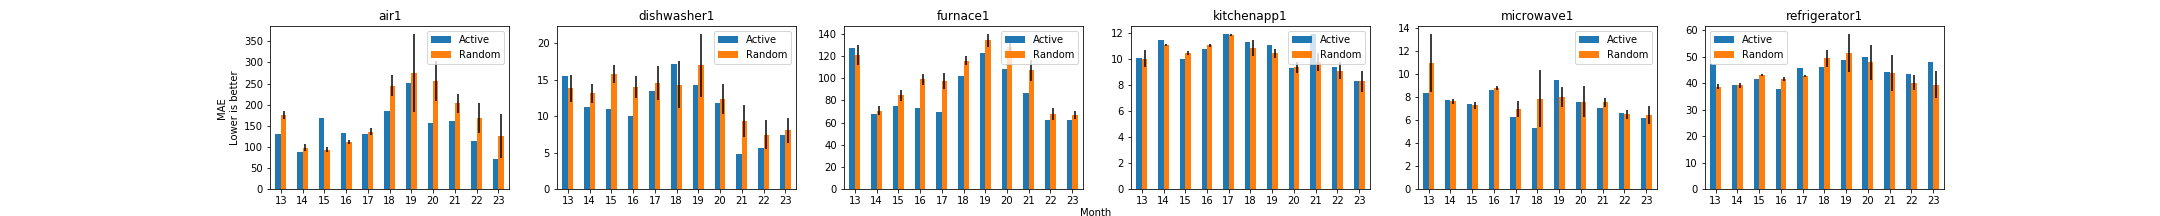

In [37]:
from IPython.display import Image
Image('comparison-active.png')

In [27]:
chosen_homes = {12:[(5357, 'refrigerator1'), (5357, 'dishwasher1'), (4336, 'kitchenapp1'), (4336, 'air1'), (5357, 'microwave1')],
               13:[(3916, 'air1'), (7016, 'furnace1'), (5357, 'kitchenapp1'), (7719, 'refrigerator1'), (4154, 'air1')],
               14:[(2365, 'refrigerator1'), (4375, 'microwave1'), (2365, 'furnace1'), (7719, 'air1'), (4375, 'kitchenapp1')],
               15:[(1700, 'dishwasher1'), (7719, 'furnace1'), (1700, 'microwave1'), (3918, 'furnace1'), (3918, 'kitchenapp1')],
               16: [(1700, 'kitchenapp1'), (5357, 'air1'), (7719, 'dishwasher1'), (2018, 'air1'), (5357, 'furnace1')],
               17: [(7719, 'microwave1'), (2365, 'air1'), (484, 'dishwasher1'), (3044, 'kitchenapp1'), (1790, 'kitchenapp1')],
               18:[(2018, 'dishwasher1'), (7016, 'refrigerator1'), (4957, 'refrigerator1'), (4375, 'refrigerator1'), (3039, 'dishwasher1')],
               19:[(5972, 'refrigerator1'), (5972, 'air1'), (484, 'refrigerator1'), (6691, 'microwave1'), (484, 'air1')],
               20:[(3039, 'furnace1'), (1507, 'kitchenapp1'), (7719, 'kitchenapp1'), (7793, 'furnace1'), (6691, 'kitchenapp1')],
               21:[(4154, 'kitchenapp1'), (3916, 'kitchenapp1'), (3918, 'air1'), (3039, 'kitchenapp1'), (1790, 'air1')],
               22:[(7016, 'air1'), (1507, 'air1'), (3039, 'refrigerator1'), (4767, 'air1'), (1700, 'furnace1')],
               23:[(2018, 'refrigerator1'), (7793, 'refrigerator1'), (5972, 'furnace1'), (3044, 'refrigerator1'), (3039, 'air1')]}

In [28]:
homes = chosen_homes[x][

SyntaxError: unexpected EOF while parsing (<ipython-input-28-defaef61a8b1>, line 1)

In [29]:
pd.Series([x[0] for x in chosen_homes[12]]).value_counts()

5357    3
4336    2
dtype: int64

In [30]:
all_homes = np.array([[x[0] for x in chosen_homes[m]] for m in range(13, 24)]).flatten()

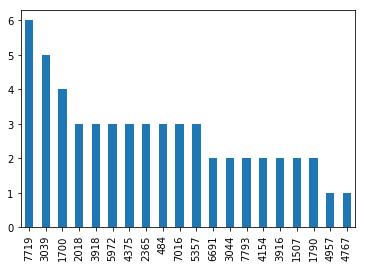

In [31]:
pd.Series(all_homes).value_counts().plot(kind='bar')

In [32]:
np.searchsorted(use_homes, 7719)

152

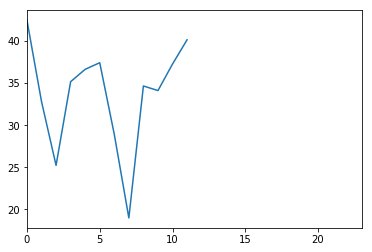

In [43]:
pd.DataFrame(t[152, :, :]).iloc[2].plot()

In [34]:
p_m_h[13]

[(499, 'air1'),
 (499, 'furnace1'),
 (499, 'kitchenapp1'),
 (499, 'refrigerator1'),
 (503, 'air1'),
 (503, 'dishwasher1'),
 (503, 'furnace1'),
 (503, 'kitchenapp1'),
 (503, 'microwave1'),
 (503, 'refrigerator1'),
 (744, 'air1'),
 (781, 'air1'),
 (781, 'dishwasher1'),
 (781, 'furnace1'),
 (781, 'kitchenapp1'),
 (781, 'microwave1'),
 (781, 'refrigerator1'),
 (871, 'air1'),
 (871, 'dishwasher1'),
 (871, 'furnace1'),
 (871, 'kitchenapp1'),
 (871, 'microwave1'),
 (871, 'refrigerator1'),
 (974, 'air1'),
 (1086, 'air1'),
 (1086, 'dishwasher1'),
 (1086, 'furnace1'),
 (1086, 'microwave1'),
 (1086, 'refrigerator1'),
 (1103, 'air1'),
 (1169, 'air1'),
 (1169, 'dishwasher1'),
 (1169, 'furnace1'),
 (1169, 'kitchenapp1'),
 (1169, 'microwave1'),
 (1169, 'refrigerator1'),
 (1192, 'air1'),
 (1202, 'air1'),
 (1202, 'dishwasher1'),
 (1202, 'furnace1'),
 (1415, 'air1'),
 (1415, 'dishwasher1'),
 (1415, 'furnace1'),
 (1415, 'kitchenapp1'),
 (1415, 'microwave1'),
 (1415, 'refrigerator1'),
 (1500, 'air1'),
 (1

In [19]:
{x:len(p_m_h[x]) for x in p_m_h.keys()}


{12: 361,
 13: 361,
 14: 361,
 15: 361,
 16: 361,
 17: 361,
 18: 356,
 19: 356,
 20: 356,
 21: 356,
 22: 356,
 23: 352}

In [146]:
np.isfinite(t[:, 2:, -1].flatten()).sum()

366

In [147]:
p_m_h = {}
for month in range(23, 24):
    p_m_h[month] = []
    for home in pool_homes:
        print(home)
        for i, appliance in enumerate(APPLIANCE_ORDER[1:]):
            pool_home_index  = np.searchsorted(use_homes, home)
            if np.isfinite(t[pool_home_index, i+1, month]):
                p_m_h[month].append((home, appliance))

484
499
503
545
624
744
781
871
946
974
1086
1103
1169
1192
1202
1283
1403
1415
1463
1500
1507
1589
1617
1632
1642
1697
1700
1718
1790
1800
1953
2018
2094
2129
2156
2171
2199
2233
2365
2378
2472
2532
2557
2575
2638
2755
2787
2814
2818
2829
2859
2945
2953
2965
3009
3039
3044
3134
3268
3310
3367
3392
3456
3482
3500
3527
3538
3577
3649
3778
3829
3831
3849
3916
3918
3935
3967
4031
4154
4213
4220
4297
4298
4336
4342
4352
4357
4373
4375
4473
4514
4641
4767
4874
4946
4957
4998
5026
5060
5129
5218
5275
5317
5357
5403
5545
5568
5677
5718
5785
5809
5814
5874
5889
5921
5949
5959
5972
6061
6063
6121
6139
6165
6348
6412
6423
6460
6498
6691
6692
6730
6990
7016
7030
7361
7390
7429
7504
7536
7560
7627
7641
7719
7731
7769
7787
7788
7793
7850
7875
7900
7901
7940
7951
7973
7989
8046
8059
8079
8084


In [148]:
len(pool_homes)

160

In [149]:
pool_home_index

169

In [150]:
np.searchsorted(use_homes, 8084)

169

In [151]:
np.isfinite(t[pool_home_index, i+1, month])

False

In [159]:
t[169, 1].shape

(24,)

In [162]:
np.isfinite(t[169].flatten()).sum()

48

In [163]:
p_m_h

{23: [(499, 'air1'),
  (499, 'furnace1'),
  (499, 'kitchenapp1'),
  (499, 'refrigerator1'),
  (503, 'air1'),
  (503, 'dishwasher1'),
  (503, 'furnace1'),
  (503, 'kitchenapp1'),
  (503, 'microwave1'),
  (503, 'refrigerator1'),
  (744, 'air1'),
  (781, 'air1'),
  (781, 'dishwasher1'),
  (781, 'furnace1'),
  (781, 'kitchenapp1'),
  (781, 'microwave1'),
  (781, 'refrigerator1'),
  (871, 'air1'),
  (871, 'dishwasher1'),
  (871, 'furnace1'),
  (871, 'kitchenapp1'),
  (871, 'microwave1'),
  (871, 'refrigerator1'),
  (974, 'air1'),
  (1086, 'air1'),
  (1086, 'dishwasher1'),
  (1086, 'furnace1'),
  (1086, 'microwave1'),
  (1086, 'refrigerator1'),
  (1103, 'air1'),
  (1169, 'air1'),
  (1169, 'dishwasher1'),
  (1169, 'furnace1'),
  (1169, 'kitchenapp1'),
  (1169, 'microwave1'),
  (1169, 'refrigerator1'),
  (1192, 'air1'),
  (1202, 'air1'),
  (1202, 'dishwasher1'),
  (1202, 'furnace1'),
  (1415, 'air1'),
  (1415, 'dishwasher1'),
  (1415, 'furnace1'),
  (1415, 'kitchenapp1'),
  (1415, 'microwave1'